# Installations:

In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 KB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Imports:

In [3]:
import pandas as pd

import torch_geometric
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as Data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
#from torch_geometric.data import HeteroData

In [4]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Loading the data:

In [5]:
path = '/content/drive/MyDrive/Test.csv'

df = pd.read_csv(path, index_col=None, header=0, encoding="utf-8")
temp = df.head(1).values.tolist()[0]
labels = []
for i in range(1, 54, 3):
  labels.append(temp[i])

df = pd.read_csv(path, index_col=None, header=1, encoding="utf-8").drop(index=range(2))

<ipython-input-5-abcc37cff2a7>:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col=None, header=0, encoding="utf-8")
<ipython-input-5-abcc37cff2a7>:9: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col=None, header=1, encoding="utf-8").drop(index=range(2))


In [6]:
Xs = []
Ys = []
CLs = []

for l in labels:
  Xs.append(df[l].values.astype(float).tolist())
  Ys.append(df[l+'.1'].values.astype(float).tolist())
  CLs.append(df[l+'.2'].values.astype(float).tolist())

Xs = np.array(Xs)
Ys = np.array(Ys)
CLs = np.array(CLs)

weighted_mean = np.sum(Xs * CLs, axis=1) / np.sum(CLs, axis=1)
norm_Xs = (Xs - weighted_mean[:, np.newaxis])/350

weighted_mean = np.sum(Ys * CLs, axis=1) / np.sum(CLs, axis=1)
norm_Ys = (Ys - weighted_mean[:, np.newaxis])/720

In [7]:
from sklearn.feature_selection import mutual_info_regression

mi_matrix_X = np.zeros((18, 18))
mi_matrix_Y = np.zeros((18, 18))
mi_matrix_CL = np.zeros((18, 18))

for i in range(18):
    for j in range(i+1, 18):
         
        mi_X = mutual_info_regression(norm_Xs[i], norm_Xs[j], discrete_features=False)
        mi_Y = mutual_info_regression(norm_Ys[i], norm_Ys[j], discrete_features=False)
        mi_CL = mutual_info_regression(CLs[i], CLs[j], discrete_features=False)
        
        mi_matrix_X[i, j] = mi_X
        mi_matrix_X[j, i] = mi_X
        mi_matrix_Y[i, j] = mi_Y
        mi_matrix_Y[j, i] = mi_Y
        mi_matrix_CL[i, j] = mi_CL
        mi_matrix_CL[j, i] = mi_CL
        

ValueError: ignored

In [ ]:
node_mapping = dict()

for idx, lab in enumerate(labels):
  node_mapping['lab'] = idx

# Modeling the graph:

In [210]:
Xs_cov = np.corrcoef(Xs)
Ys_cov = np.corrcoef(Ys)
edj_attr_matrix = (np.square(Ys_cov) + np.square(Xs_cov))/2
print(edj_attr_matrix.astype(np.double))

[[1.         0.94908408 0.93980903 0.59991523 0.63946063 0.83034849
  0.8252035  0.81355121 0.66410295 0.77634551 0.76065985 0.55054154
  0.52658398 0.19743987 0.61739548 0.60999778 0.55439148 0.97429513]
 [0.94908408 1.         0.91523518 0.6064785  0.62418186 0.85539316
  0.7936268  0.82862571 0.65117483 0.78389374 0.72775083 0.56115346
  0.53050381 0.21021096 0.61623938 0.62219154 0.56390192 0.94811628]
 [0.93980903 0.91523518 1.         0.57469535 0.68651147 0.78977271
  0.83532133 0.78939006 0.67783015 0.74203745 0.7390282  0.54836145
  0.54049349 0.18287964 0.62865023 0.59622682 0.56333622 0.93633492]
 [0.59991523 0.6064785  0.57469535 1.         0.39510826 0.53528559
  0.55246602 0.56708888 0.49906882 0.53126238 0.50434884 0.44704423
  0.43125568 0.06306662 0.46894976 0.47590327 0.439365   0.60676342]
 [0.63946063 0.62418186 0.68651147 0.39510826 1.         0.59128252
  0.66602965 0.6043194  0.54196246 0.55608053 0.55982752 0.46248744
  0.4699478  0.20170219 0.53835368 0.4472887

In [ ]:
# def set_edges(epoch_len, land_mark_num, encoders=None):
#     src = []
#     dst = []
#     edge_attr_list = []

#     for n in range(epoch_len):
#       for i in range(land_mark_num):
#         src.append(n*land_mark_num + i)
#         dst.append(n*land_mark_num + i + land_mark_num)
#         edge_attr_list 

#       for i in range(land_mark_num):
#         for j in range(land_mark_num):
#           if i != j:
#             src.append(i + n*land_mark_num)
#             dst.append(j + n*land_mark_num)

#     edge_index = torch.tensor([src, dst])

#     #edge_attr = edj_attr_matrix[]
#     # if encoders is not None:
#     #     edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
#     #     edge_attr = torch.cat(edge_attrs, dim=-1)

#     return edge_index, edge_attr

In [9]:
def set_nodes(Xs, Ys, CLs, off_idx, land_mark_num, epoch_len, encoders=None):
  x = torch.tensor([])

  for n in range(epoch_len):
    for i in range(land_mark_num):
      step = torch.tensor([[float(Xs[i, n + off_idx])], 
                           [float(Ys[i, n + off_idx])], 
                           [float(CLs[i, n + off_idx])]], 
                          dtype=torch.float)
      x = torch.cat((x, step.T), dim=0)
  return x

In [10]:
num_landmarks = 18
num_layers = 120
edge_index = []

# Connect each landmark to all other landmarks in the same layer
for layer in range(num_layers):
    start = layer * num_landmarks
    layer_edges = [(i, j) for i in range(start, start + num_landmarks) for j in range(start, start + num_landmarks) if i != j]
    layer_edges = [[edge[0], edge[1]] for edge in layer_edges]
    edge_index.extend(layer_edges)

# Connect each landmark to the same landmark in the next layer
for layer in range(num_layers - 1):
    start1 = layer * num_landmarks
    start2 = (layer + 1) * num_landmarks
    layer_edges = [[i, j] for i in range(start1, start1 + num_landmarks) for j in range(start2, start2 + num_landmarks) if i % num_landmarks == j % num_landmarks]
    edge_index.extend(layer_edges)
    
edge_index = torch.tensor(edge_index).t().contiguous()


In [11]:
num_landmarks = 18
num_layers = 120
edge_index = []
edge_attr = []

# Connect each landmark to all other landmarks in the same layer
for layer in range(num_layers):
    start = layer * num_landmarks
    layer_edges = [(i, j) for i in range(start, start + num_landmarks) for j in range(start, start + num_landmarks) if i != j]
    layer_edges = [[edge[0], edge[1]] for edge in layer_edges]
    edge_index.extend(layer_edges)
    edge_attr.extend([edj_attr_matrix[i % num_landmarks, j % num_landmarks] for i, j in layer_edges])

# Connect each landmark to the same landmark in the next layer
for layer in range(num_layers - 1):
    start1 = layer * num_landmarks
    start2 = (layer + 1) * num_landmarks
    layer_edges = [[i, j] for i in range(start1, start1 + num_landmarks) for j in range(start2, start2 + num_landmarks) if i % num_landmarks == j % num_landmarks]
    edge_index.extend(layer_edges)
    edge_attr.extend([1 for _ in layer_edges])
    
edge_index = torch.tensor(edge_index).double().t().contiguous()
edge_attr = torch.tensor(edge_attr).unsqueeze(-1)


In [12]:
from torch_geometric.data import Data

epoch_len = 120
land_mark_num = 18
len = df.shape[0]-1
overlap = 0.5
graph_list = []
order = []
count = 0
step = int(epoch_len*(1-overlap))

#edge_index, edge_attr = set_edges(epoch_len, land_mark_num)

for i in range(1, len+1-2*step, step):
  x = set_nodes(norm_Xs, norm_Ys, CLs, i, land_mark_num, epoch_len)
  data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
  graph_list.append(data)
  count = count + 1
  order.append((count, i))

* **Create and save the dataset:**

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

loader = DataLoader(graph_list, batch_size=16)
torch.save(loader, '/content/drive/MyDrive/Test_loader.pth')

pd.DataFrame(order).to_csv('/content/drive/MyDrive/order.csv')

In [ ]:
from torch_geometric.data import Data, DataLoader, InMemoryDataset

dataset = InMemoryDataset(root='/content/', transform=None)
dataset.data = graph_list
dataset.index_select = None

# Save the dataset to disk
torch.save(dataset, './dataset.pt')

# Load the dataset from disk
dataset2 = torch.load('./dataset.pt')

# Print the first data object in the dataset
print(dataset2[0])

[Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 38862]), Data(x=[2160, 3], edge_index=[2, 

In [ ]:
import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url

root = '/content/drive/MyDrive/Test_loader.pth'

class Dataset1(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [ ]:
dataloader = DataLoader(dataset, batch_size=16)

# Training the Attentional Variational Graph Autoencoder:

In [228]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch_geometric.utils import to_dense_batch
import numpy as np

# Define the number of epochs to train for
num_epochs = 60

# Define the batch size for the dataloader
batch_size = 16

# Define the number of nodes and features in each node
num_nodes = 2160
num_features = 3

# Define the number of dimensions in the latent variable
hidden_dim = 24
output_dim = 6
input_dim = 3

# Define the device to use for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder and decoder architectures for the VAE

class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gmm_layers=0):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)
        # self.gmm_layers = torch.nn.ModuleList()
        # for i in range(num_gmm_layers):
        #     self.gmm_layers.append(GMMConv(hidden_dim, hidden_dim, kernel_size=25, dim=3))
        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gat1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat2(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat3(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        # for gmm_layer in self.gmm_layers:
        #     x = gmm_layer(x, edge_index, edge_attr)
        #     x = F.elu(x)
        #     x = F.dropout(x, p=0.4, training=self.training)

        # x = global_add_pool(x, batch)
        # x, batch = to_dense_batch(x, batch=batch)
        
        x = self.conv_mu(x, edge_index)

        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)
        # x = self.global_pool(x)
        z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std

# class Encoder(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(Encoder, self).__init__()
#         self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
#         self.conv1 = GCNConv(input_dim, hidden_dim)
#         self.conv_mu = GCNConv(hidden_dim, output_dim)
#         self.conv_logstd = GCNConv(hidden_dim, output_dim)
#         self.att_lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
#         self.att_lin2 = torch.nn.Linear(hidden_dim, 1)

#     def forward(self, x, edge_index):
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.relu(self.lin1(x))
#         x = F.dropout(x, p=0.2, training=self.training)
#         attn_coef = F.softmax(self.att_lin2(F.relu(self.att_lin1(x))), dim=1)
#         x = self.conv_mu(x, edge_index)
#         x = attn_coef * x
#         return x

# class Decoder(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(Decoder, self).__init__()
#         self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
#         self.lin2 = torch.nn.Linear(hidden_dim, output_dim)
#         self.conv1 = GCNConv(input_dim, hidden_dim)
#         self.conv_mu = GCNConv(hidden_dim, output_dim)
#         self.conv_logstd = GCNConv(hidden_dim, output_dim)

#     def forward(self, x, edge_index):
#         x = F.relu(self.conv1(x, edge_index))
#         x = self.conv_mu(x, edge_index)
#         return x

class Decoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index, edge_attr):
        z = self.lin1(z)
        z = F.relu(z)
        z = self.conv1(z, edge_index) # assuming edge_index is a parameter
        z = F.relu(z)
        z = self.conv2(z, edge_index)
        z = F.relu(z)
        z = self.lin2(z)
        z = F.relu(z)
        z = self.conv3(z, edge_index)
        z = F.relu(z)
        z = self.lin3(z)
        z = torch.sigmoid(z)
        return z


class AttentionalGraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionalGraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, output_dim)
        self.decoder = Decoder(output_dim, hidden_dim, input_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        # z_mean, z_log_std = self.encoder(x, edge_index, edge_attr)
        # x_hat = self.decoder(z_mean, edge_index, edge_attr)
        # return x_hat
        z, z_mean, z_log_std = self.encoder(x, edge_index, edge_attr, batch)
        z = z_mean + torch.randn_like(z_log_std) * torch.exp(0.5 * z_log_std)
        x_hat = self.decoder(z, edge_index, edge_attr)
        return x_hat, z_mean, z_log_std

# Define the loss function for the VAE
def loss_function(x_hat, output, x, z_log_std):
    kl_loss = 0#0.5 * torch.sum(z_log_std - output**2 - 1, dim=1)
    recon_loss = F.mse_loss(x_hat, x)
    loss = recon_loss + 0.1*kl_loss
    return loss
# def loss_function(x_hat, x, z_mean, z_log_std, alpha):
#     kl_loss = 0.5 * torch.sum(z_log_std + torch.exp(z_log_std) - z_mean**2 - 1, dim=1)
#     recon_loss = F.mse_loss(x_hat, x)
#     loss = recon_loss + alpha * kl_loss
#     return loss

def kl_loss(z_mean, z_log_std):
    kl_div = -0.5 * torch.sum(1 + 2*z_log_std - z_mean.pow(2) - (2*z_log_std).exp(), dim=1)
    return torch.mean(kl_div)


In [ ]:
import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []

dataloader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)

# Initialize the attentional graph autoencoder model and move it to the device
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Define the optimizer for the VAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the VAE model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # edge_index = utils.batched_edge_indices(batch.edge_index, batch.batch).to(device)
        x_hat, z_mean, z_log_std = model(batch.x, batch.edge_index.long(), batch.edge_attr, batch.batch)
        # loss = loss_function(x_hat, z_mean, batch.x, z_log_std)
        # loss = loss_function(x_hat, batch.x, z_mean, z_log_std, alpha)
        loss = F.mse_loss(x_hat, batch.x)
        loss = loss + (1 / num_nodes) * kl_loss(z_mean, z_log_std)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs
    train_loss /= 927
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item()}')
    loss_list.append(loss.item())

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/60: Loss=0.29444223642349243
Epoch 2/60: Loss=1.3330869674682617
Epoch 3/60: Loss=0.6185651421546936
Epoch 4/60: Loss=0.584070086479187
Epoch 5/60: Loss=0.5682717561721802
Epoch 6/60: Loss=366798624.0
Epoch 7/60: Loss=0.4962220788002014
Epoch 8/60: Loss=1001550.4375
Epoch 9/60: Loss=0.5045021772384644


# Evaluating:

In [203]:
output = model.encoder(graph_list[0].x, graph_list[0].edge_index.long(), graph_list[0].edge_attr, graph_list[0].batch)

In [204]:
output[0].shape

torch.Size([1, 6])

In [162]:
model.eval()

AttentionalGraphAutoencoder(
  (encoder): Encoder(
    (gat1): GATConv(3, 16, heads=1)
    (gat2): GATConv(16, 16, heads=1)
    (gat3): GATConv(16, 16, heads=1)
    (lin): Linear(in_features=16, out_features=6, bias=True)
    (lin_mean): Linear(in_features=6, out_features=6, bias=True)
    (lin_logstd): Linear(in_features=6, out_features=6, bias=True)
    (conv_mu): GCNConv(16, 16)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=6, out_features=16, bias=True)
    (conv1): GCNConv(16, 16)
    (conv2): GCNConv(16, 16)
    (lin2): Linear(in_features=16, out_features=16, bias=True)
    (conv3): GCNConv(16, 16)
    (lin3): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [126]:
state_dict = model.state_dict()

# Save the state dictionary to a file
torch.save(state_dict, 'my_model1.pt')

In [ ]:
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Load the saved state dictionary into the model
state_dict = torch.load('my_model1.pt')
model.load_state_dict(state_dict)

# Embedding the graphs and saving:

In [132]:
# Embed the input graphs using the trained VAE
embeddings = []

for graph in graph_list:
    graph = graph.to(device)
    with torch.no_grad():
        output = model.encoder(graph.x, graph.edge_index.long(), graph.edge_attr)
    embeddings.append(output[0].cpu().numpy())

embeddings = np.array(embeddings)
np.save('embeddings1.npy', embeddings)

In [140]:
embeddings = np.array(embeddings)
np.save('node_embeddings.npy', embeddings)

Reload:

In [ ]:
embeddings = np.load('/content/node_embeddings.npy')
embs = 

In [138]:
embeddings2 = np.array(embeddings[:,105,:])

Visualizing the embedded data:

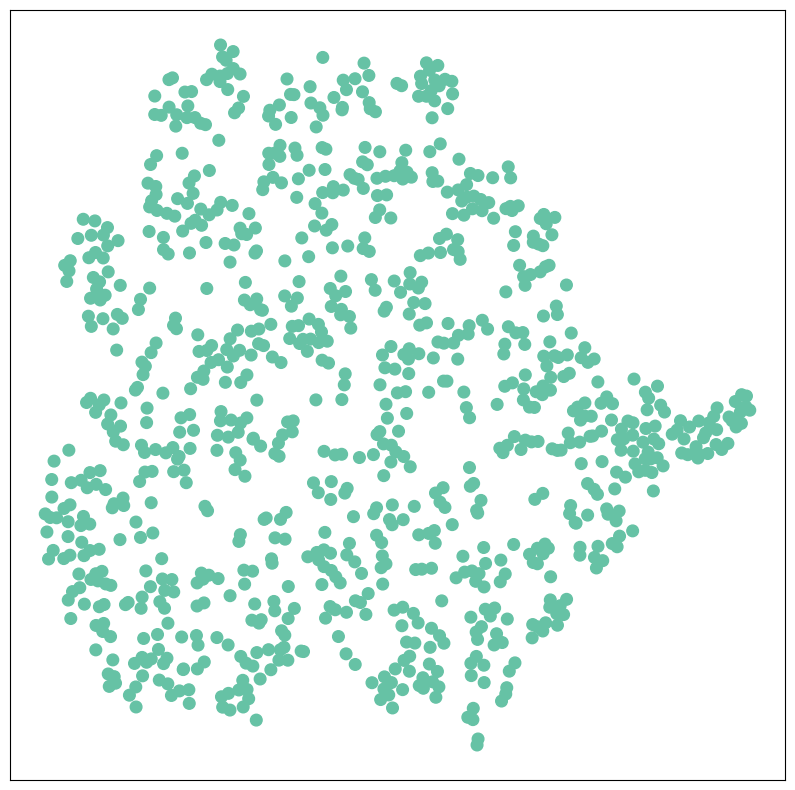

In [139]:
visualize(torch.tensor(embeddings2), color=np.zeros([1,927]))

# Clustering the Graphs:

In [144]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Load the embedded graph data
# embeddings = np.load('embeddings.npy')

# Set the number of clusters
num_clusters = 8

# Initialize the GMM model
gmm = GaussianMixture(n_components=num_clusters)

# Fit the GMM model to the embedded data
gmm.fit(embeddings2)

# Predict the cluster labels for the embedded data
cluster_labels = gmm.predict(embeddings2)
print(cluster_labels)

[2 2 2 2 2 0 5 1 0 2 6 2 0 1 4 2 4 6 7 6 4 6 0 2 5 2 5 5 5 5 4 6 7 0 4 4 6
 5 1 6 6 6 1 1 4 1 6 7 7 0 4 4 6 4 7 6 1 1 7 2 4 1 1 6 5 5 7 4 5 2 4 6 2 5
 2 2 2 2 2 0 6 0 2 2 7 7 0 7 1 0 1 6 1 6 6 0 5 0 2 4 6 6 5 0 6 6 0 6 1 1 5
 1 1 2 0 7 6 4 7 1 7 4 1 5 1 4 6 7 0 0 0 2 1 4 6 4 1 1 1 1 7 7 4 7 4 6 4 7
 5 4 0 5 4 4 6 1 4 1 6 7 7 0 2 2 5 0 0 2 6 5 0 2 2 4 0 6 0 4 0 4 5 0 1 0 0
 5 4 4 0 2 0 6 1 7 4 6 7 3 5 5 5 2 4 5 5 3 2 2 2 2 0 6 5 0 2 5 5 0 5 0 5 2
 2 7 2 4 4 0 7 1 1 4 1 4 7 1 1 7 1 1 1 5 5 1 1 1 0 7 7 7 1 1 7 7 1 7 1 6 1
 4 4 2 7 1 5 7 4 6 2 6 5 2 1 1 0 2 6 1 4 1 2 0 7 4 7 7 5 4 6 0 0 5 0 5 2 6
 5 5 0 0 2 0 0 0 0 7 2 7 7 0 6 5 5 4 5 4 4 4 7 1 4 2 0 5 1 6 4 5 7 0 0 6 0
 2 5 5 4 2 7 6 6 2 1 2 1 6 7 0 2 0 6 2 0 6 0 2 2 0 5 6 0 4 6 6 2 2 7 1 5 2
 6 0 1 2 2 4 4 5 6 1 0 2 5 4 0 5 2 0 2 1 4 6 5 5 5 5 6 1 0 0 2 0 6 0 2 2 0
 0 4 4 6 1 4 7 4 7 4 7 4 4 6 4 1 2 4 6 2 4 2 6 4 2 1 4 0 0 4 2 5 2 2 5 5 2
 6 0 0 5 0 7 4 6 7 6 6 5 5 5 3 1 1 4 4 2 4 1 6 6 6 2 7 0 5 1 4 6 4 6 2 1 2
 1 2 2 0 2 2 4 4 6 4 4 6 

In [146]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 38.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-linux_x86_64.whl size=3582374 sha256=f3312fc065eee324944be97b5c4b0d2a37874ee6aa9fcfc04ca748236aeab495
  Stored in directory: /root/.cache/pip/wheels/05/6f/88/1a4c04276b98306f00217a1e300e6ba0252c6aa4f7616067ae
Successfully built hdbscan


In [ ]:
import hdbscan

# Assuming your 6x1000 array is called `embedded_graph`
# Transpose the array so that each row represents a data point and each column represents a feature
embedded_graph = embeddings2

# Cluster the data using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels2 = clusterer.fit_predict(embedded_graph)

# Print the number of clusters found
num_clusters = len(set(cluster_labels2)) - (1 if -1 in cluster_labels2 else 0)
print(f"Number of clusters: {num_clusters}")

# Print the cluster labels for each data point
print("Cluster labels:")
print(cluster_labels2)

# Analysis:

transition matrix:

In [ ]:
def calculate_transition_matrix(states):
    # Get unique state values
    unique_states = np.unique(cluster_labels)

    # Calculate the size of the transition matrix
    matrix_size = len(unique_states)

    # Create an empty transition matrix
    transition_matrix = np.zeros((matrix_size, matrix_size))

    # Calculate the number of transitions between each pair of states
    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        current_state_index = np.where(unique_states == current_state)[0][0]
        next_state_index = np.where(unique_states == next_state)[0][0]
        transition_matrix[current_state_index][next_state_index] += 1

    # Normalize the transition matrix
    row_sums = np.sum(transition_matrix, axis=1)
    transition_matrix = np.divide(transition_matrix, row_sums[:, np.newaxis])

    return transition_matrix

histogram:

In [ ]:
plt.hist(cluster_labels, bins=8)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

transition graph: